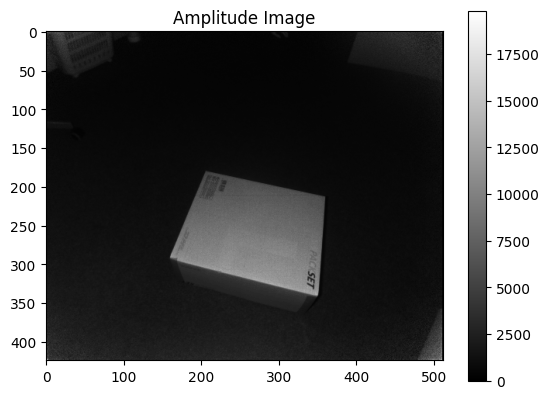

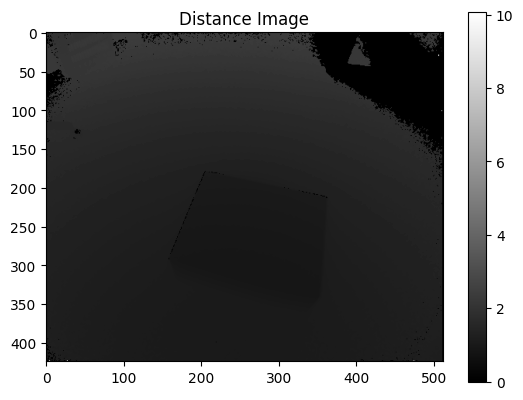

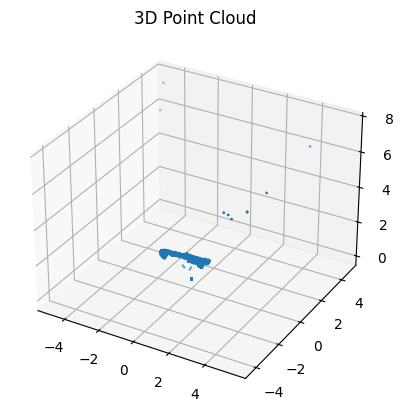

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load your data
amplitude_image, distance_image, point_cloud = load_data('data/example2kinect.mat')

# Display images
show_image(amplitude_image, 'Amplitude Image')
show_image(distance_image, 'Distance Image')

# Display point cloud
show_point_cloud(point_cloud)


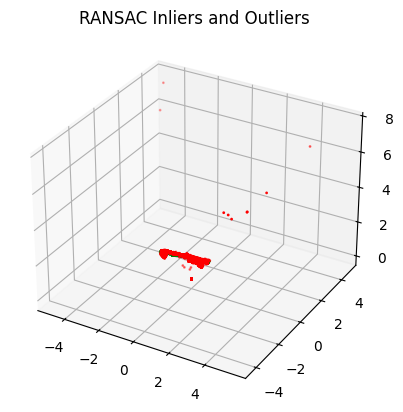

In [4]:
import numpy as np

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = []

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(pc.shape[0] * pc.shape[1], 3, replace=False)
        samples = pc.reshape(-1, 3)[sample_indices]

        if np.any(samples[:, 2] == 0):  # Skip if any z-component is zero (invalid data)
            continue

        # Calculate plane parameters
        p1, p2, p3 = samples
        normal_vector = np.cross(p2 - p1, p3 - p1)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        d = -np.dot(normal_vector, p1)

        # Count inliers
        all_points = pc.reshape(-1, 3)
        distances = np.abs(np.dot(all_points, normal_vector) + d) / np.linalg.norm(normal_vector)
        inliers = distances < threshold

        # Update best model if current one has more inliers
        if inliers.sum() > len(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers

    return best_plane, best_inliers

# Parameters
threshold = 0.05  # Distance threshold for inliers
max_iterations = 5000  # Maximum number of iterations

# Assuming point_cloud is the loaded 3D point cloud data
plane, inliers = ransac_point_cloud(point_cloud, threshold, max_iterations)

# Visualize the result
def visualize_inliers(pc, inliers):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    inlier_points = pc.reshape(-1, 3)[inliers]
    outlier_points = pc.reshape(-1, 3)[~inliers]
    ax.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2], color='r', s=1)
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], color='g', s=1)
    ax.set_title('RANSAC Inliers and Outliers')
    plt.show()

visualize_inliers(point_cloud, inliers)


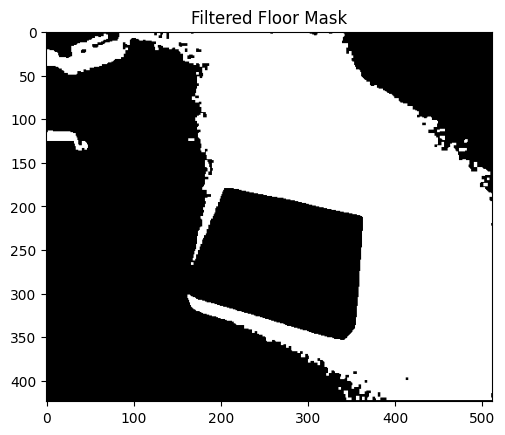

In [5]:
import scipy.ndimage as ndimage

def apply_morphological_filters(binary_mask, size=3):
    # Apply binary closing and opening to remove noise and fill gaps
    structure = np.ones((size, size))
    closed_mask = ndimage.binary_closing(binary_mask, structure=structure)
    cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)
    return cleaned_mask

# Convert inliers to a binary mask
binary_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
binary_mask[inliers.reshape(point_cloud.shape[:2])] = True

# Apply morphological filtering
cleaned_mask = apply_morphological_filters(binary_mask)

# Visualization function for the mask
def show_mask(mask, title):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.show()

show_mask(cleaned_mask, 'Filtered Floor Mask')


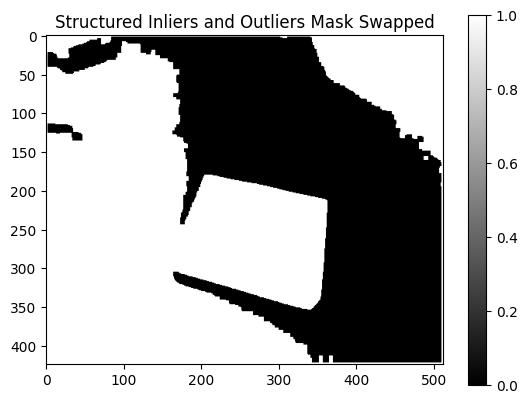

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

def apply_morphological_filters(binary_mask, size=3):
    """ Apply binary closing and opening to remove noise and fill gaps """
    structure = np.ones((size, size))
    closed_mask = ndimage.binary_closing(binary_mask, structure=structure)
    cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)
    return cleaned_mask

# Assuming binary_mask is created from original inliers
# binary_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
# binary_mask[inliers.reshape(point_cloud.shape[:2])] = True

def create_full_structure_mask(cleaned_mask, point_cloud):
    """ Create a full-size mask, and then invert the inliers and outliers """
    # Initialize a full-size mask with False (indicating outliers)
    full_size_mask = np.full(point_cloud.shape[:2], False, dtype=bool)
    # Update this mask with the cleaned mask where inliers are set to True
    full_size_mask[cleaned_mask] = True
    # Invert the mask to swap True and False
    full_size_mask = ~full_size_mask
    return full_size_mask

# Apply morphological filters
cleaned_mask = apply_morphological_filters(binary_mask, size=5)

# Create a full structured mask
structured_inliers_mask = create_full_structure_mask(cleaned_mask, point_cloud)

def show_mask(mask, title):
    """ Visualization function for the mask """
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Show the structured mask with inliers as False and outliers as True
show_mask(structured_inliers_mask, 'Structured Inliers and Outliers Mask Swapped')


In [18]:
import numpy as np

def extract_inlier_points_and_indices(point_cloud, mask):
    """Extract points and their indices from the point cloud based on the mask,
    retaining the original structured dimensions."""
    # Initialize an array to store inlier points with the same shape as the point cloud
    inlier_points = np.full(point_cloud.shape, np.nan)  # Fill with NaNs for non-inliers
    # Apply the mask to fill only inlier points
    inlier_points[mask] = point_cloud[mask]
    # Extract indices where the mask is True
    inlier_indices = np.argwhere(mask)
    return inlier_points, inlier_indices

# Assuming 'point_cloud' and 'structured_inliers_mask' are defined
inlier_points, inlier_indices = extract_inlier_points_and_indices(point_cloud, structured_inliers_mask)


TypeError: Invalid shape (217088,) for image data

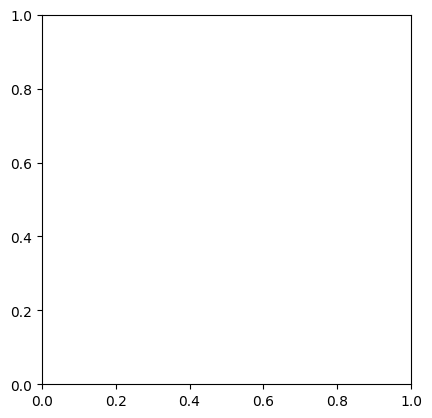

In [19]:
def ransac_on_inliers(points, indices, original_shape, threshold=0.01, max_iterations=5000):
    best_plane = None
    best_inliers = np.array([])
    num_points = len(points)

    for _ in range(max_iterations):
        if num_points < 3:
            continue
        sample_indices = np.random.choice(num_points, 3, replace=False)
        p1, p2, p3 = points[sample_indices]

        normal_vector = np.cross(p2 - p1, p3 - p1)
        normal_vector /= np.linalg.norm(normal_vector)
        d = -np.dot(normal_vector, p1)

        distances = np.abs(np.dot(points, normal_vector) + d) / np.linalg.norm(normal_vector)
        inliers = distances < threshold

        if inliers.sum() > best_inliers.sum():
            best_plane = (normal_vector, d)
            best_inliers = inliers

    # Create a full-size mask with False values
    full_size_mask = np.zeros(original_shape, dtype=bool)
    # Only set those indices that are inliers according to the RANSAC result
    full_size_mask[np.unravel_index(indices[best_inliers], original_shape)] = True
    return best_plane, full_size_mask

# Assuming point_cloud, inlier_points, and inlier_indices are defined
height, width, _ = point_cloud.shape
# plane, full_size_inlier_mask = ransac_on_inliers(inlier_points, inlier_indices, (height, width))
plane, full_size_inlier_mask = ransac_point_cloud(inlier_points, threshold=0.01, max_iterations=5000)
def show_mask(mask, title):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Display the full-size inlier mask
show_mask(full_size_inlier_mask, 'Full-Size Inlier Mask')


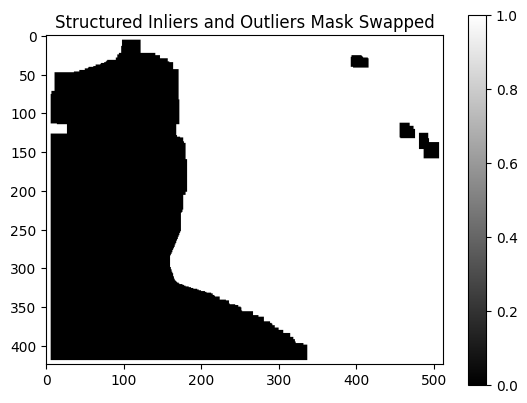

In [9]:
def visualize_ransac_results(points, inliers):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', s=1)  # All points in blue
    ax.scatter(points[inliers, 0], points[inliers, 1], points[inliers, 2], color='g', s=1)  # Inliers in green
    ax.set_title('RANSAC Results: Inliers (Green) and Outliers (Blue)')
    plt.show()

cleaned_mask2 = apply_morphological_filters(full_size_inlier_mask, size=12)
cleaned_mask2 = apply_morphological_filters(cleaned_mask2, size=3)

# Create a full structured mask
structured_inliers_mask2 = create_full_structure_mask(cleaned_mask2, point_cloud)
# Show the structured mask with inliers as False and outliers as True
show_mask(structured_inliers_mask2, 'Structured Inliers and Outliers Mask Swapped')
